This notebook allows you to run ACOLITE/RAdCor processing for Sentinel-2 MSI scenes on Google Colab. RAdCor is an atmospheric correction algorithm that can account for adjacency effects explicitly, by using realistic atmospheric point spread functions. RAdCor development was funded by the [BELSPO/STEREO programme](https://www.belspo.be/belspo/space/belspo_stereo_en.stm) under contract SR/00/406. For more information on RAdCor, check out the [website](https://odnature.naturalsciences.be/radcor/), [publication](https://doi.org/10.1364/AO.546766), and [ATBD](https://github.com/acolite/radcor_atbd).

To run the code in the notebook, click the execute button next to each cell to run that particular cell. Since cells use outputs from preceding cells, please run them in order.

The required dependencies are installed and the latest version of ACOLITE is cloned from [GitHub](https://github.com/acolite/acolite). The first run of a specific sensor will be slower as the sensor specific lookup tables (LUTs) are retrieved. Please note that all data (including LUTs) and installed software in the Colab instance are deleted after it expires. For more than occasional processing it is recommended to set up a local environment and install the software on your system.

In this example, Sentinel-2 scenes are retrieved from the Copernicus Data Space Ecosystem (CDSE) and hence requires CDSE credentials to be configured. If you have no such account, please register at [CDSE](https://dataspace.copernicus.eu/). Download speed of a scene to Google Drive will depend on the CDSE connection, and typically takes a few minutes.

Optional ancillary data can be used if EarthData credentials are also set up. Register at the [EarthData Login](https://urs.earthdata.nasa.gov/) page and select OB.DAAC Data Access and LP DAAC Data Pool in your profile under Authorised Apps, Approve More Applications.

Author: Quinten Vanhellemont, RBINS, quinten.vanhellemont@naturalsciences.be
Created: 2025-07-01

In [11]:
# general imports
import os, sys

The next cell installs ACOLITE dependencies using pip. The exclamation point before pip is a Jupyter notebook magic command that executes an operating system shell command directly from the notebook. We first try to import NetCDF, and assume if this fails that the dependencies have not been installed yet. This is a cell specific for colab, and would not typically be needed for local runs of ACOLITE.

In [2]:
## try to import NetCDF4, under the assumption if this works the dependencies are installed
try:
  import netCDF4
except:
  !pip install numpy matplotlib scipy gdal pyproj scikit-image pyhdf pyresample netcdf4 h5py requests pygrib cartopy

The next cell imports the Python os package, and if needed clones the ACOLITE repository from GitHub. Again the "!" magic command is used to run in the command shell. This is a cell specific for colab, and would not typically be needed for local runs of ACOLITE.

In [3]:
## check if we need to clone ACOLITE
if not os.path.exists('acolite'):
  !git clone --depth 1 https://github.com/acolite/acolite

Cloning into 'acolite'...
remote: Enumerating objects: 2730, done.
remote: Counting objects: 100% (2730/2730), done.
remote: Compressing objects: 100% (2582/2582), done.
remote: Total 2730 (delta 174), reused 2392 (delta 115), pack-reused 0 (from 0)
Receiving objects: 100% (2730/2730), 7.67 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (174/174), done.


The next cell adds the ACOLITE clone location to the system path, and imports the ACOLITE code.

In [12]:
## add acolite to path and import
sys.path.append('acolite')
import acolite as ac

The next cell sets your CSDE username (CDSE_u) and password (CDSE_p) as environment variables, to be entered as strings.

In [16]:
## CDSE credentials are needed for retrieving data
## add CDSE credentials to environment variables
os.environ['CDSE_u'] = 'zhuxiaobo1992@gmail.com'
os.environ['CDSE_p'] = 'BobNJU@19921120'

If you have an EarthData account, and want to use ancillary data you can input the EARTHDATA_u and EARTHDATA_p in a similar way. Don't forget to set  settings['ancillary_data'] = True in the settings dictionary later.

In [ ]:
## EarthData credentials are needed to retrieve ancillary data
## add EarthData credentials to environment variables
os.environ['EARTHDATA_u'] = ''
os.environ['EARTHDATA_p'] = ''

Now we will set up the location and date of interest. There are several ways to set this up in ACOLITE, but here we will use a longitude and latitude of the location. You can query a range of dates, but here we will use a single date.

Here we investigate "Princess Vlei", a small lake in the South African Cape Town area. The lake has a largest dimension of around 700 m, and hence we expect strong adjacency effects. The lake is located in an urban area, and adjacency effects will manifest in all surface viewing bands due to the large contrast between built-up areas and water in all bands.


In [13]:
## location of interest
region_name = 'PrincessVlei'
station_lon = 18.4824
station_lat = -34.0483
date = '2025-05-24'

The next cell queries CDSE for Sentinel-2/MSI L1C data for the given location and date.

In [14]:
## use ACOLITE API to query CDSE
urls, scenes = ac.api.cdse.query(roi = 'POINT ({} {})'.format(station_lon, station_lat),
                                 collection = "SENTINEL-2", start_date = date, end_date = date)
## print the results
for scene in scenes:
  print(scene)

Using default product S2MSI1C for SENTINEL-2
Status code 200
Found 1 total scenes
S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.SAFE


Now we will download the scene(s) from CDSE to your Google Drive.

In [17]:
## use ACOLITE API to download the scenes from CDSE
local_scenes = ac.api.cdse.download(urls, scenes = scenes, output = 'Input/')

Download URL: https://catalogue.dataspace.copernicus.eu/odata/v1/Products(1a6da354-0615-4f32-95da-648992a75396)/$value
Writing file to Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.zip
Extracting Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.zip
Wrote Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.SAFE
Deleting Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.zip
Deleted Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.zip


In [23]:
local_scenes

['Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.SAFE']

To use ACOLITE from within Python, a settings dictionary is needed, with at minimum the inputfile and output path. We will also set a region of interest based on the longitude and latitude coordinates above, with an extent in kilometres. We select RAdCor processing, add a buffer that corresponds to the default RAdCor kernel radius, and crop to the centre area to remove this additional buffer. Feel free to experiment with enabling/disabling these options to see their impact.

Typically ACOLITE will generate a L1R NetCDF file, which is a direct conversion of the input data into a generic ACOLITE format, and a L2R file which contains the corrected data. In this example, the L1R NetCDF is deleted, and no L1R RGB files are output.

In [18]:
# acolite settings
settings = {## basic input and output settings
            ## local_scenes list is used as returned from the API download function
            'inputfile': local_scenes,
            'output': 'Output/',

            ## set up region of interest centred on lon/lat, with box size in km
            'region_name': region_name,
            'station_lon': station_lon,
            'station_lat': station_lat,
            'station_box_size': 7,
            'station_box_units': 'km',

            ## disable ancillary data retrieval, set to True if EarthData credentials are set
            'ancillary_data': False,

            ## use RAdCor processing
            'atmospheric_correction_method': 'radcor',

            ## add a buffer and crop to centre to avoid masked data around the scene edges
            'limit_buffer': 5,
            'limit_buffer_units': 'km',
            'radcor_crop_centre': True,

            ## add the following to enable SWIR based glint correction
            # 'dsf_residual_glint_correction': True,
            # 'glint_mask_rhos_threshold': 0.10,

            ## delete L1R output NetCDF
            'l1r_delete_netcdf': True,
            ## don't output L1R RGBs
            'l1r_rgb_keys': [],}

Finally, ACOLITE processing can be started. Note that the first run for a given sensor will be slower as LUTs will need to be downloaded to your Google Drive. Output data will be stored in the Output folder, accessible from the sidebar to the left.

In [19]:
## run acolite with settings dict
ret = ac.acolite.acolite_run(settings)

Running ACOLITE processing - Generic GitHub Clone c2026-01-15T07:49:34
Python - linux - 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform - Linux 6.6.105+ - x86_64 - #1 SMP Thu Oct  2 10:42:05 UTC 2025
Run ID - 20260115_080714
Creating new limit for position -34.0483N, 18.4824E, box size 7.0 km
New limit: -34.07974103494418, 18.444453669314225, -34.01685896505582, 18.520346330685772
Applying limit buffer of 5.0 km
Old limit: -34.07974103494418, 18.444453669314225, -34.01685896505582, 18.520346330685772
New limit: -34.12465679915015, 18.390244625477404, -33.97194320084984, 18.574555374522593
Identified Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.SAFE as Sentinel-2 .SAFE type
Starting conversion of 1 scenes
Starting conversion of Input//S2B_MSIL1C_20250524T081609_N0511_R121_T34HBH_20250524T115544.SAFE
Importing metadata from L1C_T34HBH_A042904_20250524T084750
Reading per pixel geometry
Computing band average per detector geometry
Detector 1
Detector 2


/content/acolite/acolite/sentinel2/l1_convert.py:398: RuntimeWarning: Mean of empty slice
  ave_vza = np.nanmean(ave_vza, axis=2)
/content/acolite/acolite/sentinel2/l1_convert.py:399: RuntimeWarning: Mean of empty slice
  ave_vaa = np.nanmean(ave_vaa, axis=2)


Detector 3
Detector 4
Detector 5
Detector 6
Wrote raa (1736, 1745)
Wrote vza (1736, 1745)
Wrote sza (1736, 1745)
Writing geolocation lon/lat
Wrote lon (1736, 1745)
Wrote lat (1736, 1745)
Converting bands
Converting bands: Wrote rhot_442 ((1736, 1745))
Converting bands: Wrote rhot_492 ((1736, 1745))
Converting bands: Wrote rhot_559 ((1736, 1745))
Converting bands: Wrote rhot_665 ((1736, 1745))
Converting bands: Wrote rhot_704 ((1736, 1745))
Converting bands: Wrote rhot_739 ((1736, 1745))
Converting bands: Wrote rhot_780 ((1736, 1745))
Converting bands: Wrote rhot_833 ((1736, 1745))
Converting bands: Wrote rhot_864 ((1736, 1745))
Converting bands: Wrote rhot_943 ((1736, 1745))
Converting bands: Wrote rhot_1377 ((1736, 1745))
Converting bands: Wrote rhot_1610 ((1736, 1745))
Converting bands: Wrote rhot_2186 ((1736, 1745))
Conversion took 15.6 seconds
Created Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L1R.nc
Running RAdCor on scene Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_Pr

/content/acolite/acolite/adjacency/radcor/radcor.py:1567: RuntimeWarning: All-NaN slice encountered
  min_pos_diff = np.nanmin(diffs)


Band index, aot 11 0.0760605113439613
Selecting best fitting model
    Model C estimated AOT(550): 0.1230 (band 8A)
    Model C tau_aer_550 CV: 0.2055
    Model M estimated AOT(550): 0.0761 (band 11)
    Model M tau_aer_550 CV: 0.2834

Estimated aerosol model: C (fitted band 8A)
Estimated aerosol optical thickness at 550 nm: 0.1230

Performing RAdCor correction
taer_550: 0.12299642484414738
Aerosol model: C
Aerosol LUT: ACOLITE-LUT-202110-MOD1
Reading raa from inputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L1R.nc
Writing raa to outputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L2R.nc
Reading vza from inputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L1R.nc
Writing vza to outputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L2R.nc
Reading sza from inputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L1R.nc
Writing sza to outputfile Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L2R.nc
Reading lon fro

We can now extract a point of interest from the created L2R scene, and plot the results of RAdCor processing with and without taking the adjacency effects into account.

In [20]:
## we can extract pixels for a box centred on the station
box_size = 11

## use the L2R files from each scene in the return dictionary
ext = {}
for n in ret:
  file = ret[n]['l2r'][0]
  print('Extracting data from {}'.format(file))
  ext[n] = ac.shared.nc_extract_point(file, station_lon, station_lat, box_size = box_size)

Extracting data from Output//S2B_MSI_2025_05_24_08_49_54_T34HBH_PrincessVlei_L2R.nc


Now, let's plot the data. In the RAdCor processing, rhos represents the surface level reflectance under the heterogeneous surface assumption (i.e. with correction for adjacency effects), and rhosu is the reflectance under the homogeneous assumption (i.e. without correction for adjacency effects).

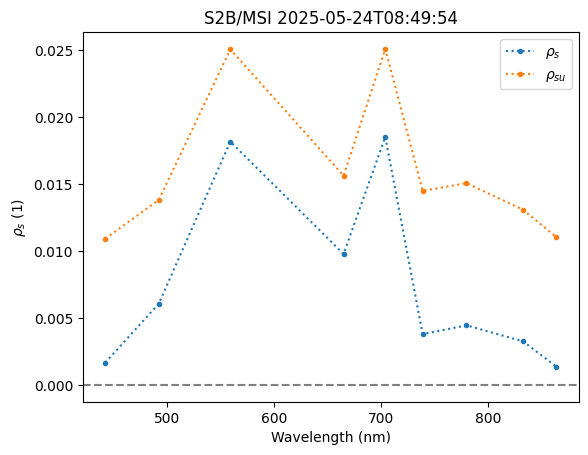

In [21]:
## import the plotting function
import matplotlib.pyplot as plt

## make plot directory
if not os.path.exists('Plots'): os.makedirs('Plots')

## run through all extracted data
for n in ext:

  ## plot the mean reflectance in the first 9 bands
  plt.plot(ext[n]['rhos_wave'][0:9], [ext[n]['mean'][ds] for ds in ext[n]['rhos_datasets']][0:9],
          '.:', label = r'$\rho_{s}$')
  plt.plot(ext[n]['rhosu_wave'][0:9], [ext[n]['mean'][ds] for ds in ext[n]['rhosu_datasets']][0:9],
          '.:', label = r'$\rho_{su}$')

  ## plot y == 0 line
  xlim = plt.xlim()
  ylim = plt.ylim()
  plt.plot(xlim, [0,0], '--', color = 'Grey')
  plt.xlim(xlim)

  ## add legend and label axes and title
  plt.legend()
  plt.xlabel('Wavelength (nm)')
  plt.ylabel(r'$\rho_s$ (1)')
  plt.title('{} {}'.format(ext[n]['gatts']['sensor'].replace('_', '/'),
                          ext[n]['gatts']['isodate'][0:19]))

  ## save plot to PNG
  plt.savefig('Plots/{}_spectra.png'.format(ext[n]['gatts']['oname']),
              dpi = 300, facecolor = 'white', bbox_inches = 'tight')

  plt.show()

We can also plot the ratio of reflectance in the green band not corrected/corrected for adjacency effects.

---



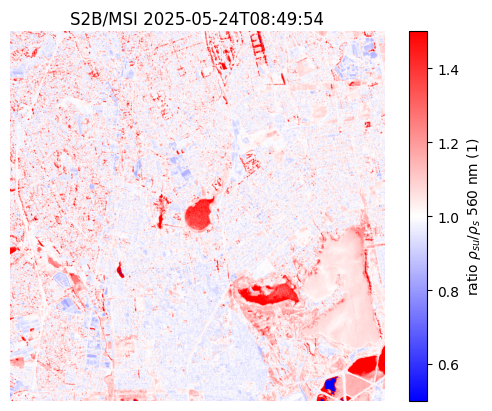

In [22]:
## import numpy for math
import numpy as np

## wavelength of band to compare
wave = 560

## find the sensor specific band wavelength
widx = np.argsort(np.abs(np.asarray(ext[n]['rhos_wave'])-wave))[0]

## get rhos and rhosu datasets for this band
rhos_ds = ext[n]['rhos_datasets'][widx]
rhos_d = ac.shared.nc_data(file, rhos_ds)
rhosu_ds = ext[n]['rhosu_datasets'][widx]
rhosu_d = ac.shared.nc_data(file, rhosu_ds)

## compute ratio of rhosu/rhos
ratio = rhosu_d/rhos_d

## plot image
plt.imshow(ratio, vmin = 0.5, vmax = 1.5, cmap = 'bwr')
plt.colorbar(label = 'ratio {}/{} {} nm (1)'.format(r'$\rho_{su}$', r'$\rho_{s}$', wave, ))
plt.axis('off')
plt.title('{} {}'.format(ext[n]['gatts']['sensor'].replace('_', '/'),
                          ext[n]['gatts']['isodate'][0:19]))

## save plot to PNG
plt.savefig('Plots/{}_ratio_{}.png'.format(ext[n]['gatts']['oname'], wave),
              dpi = 300, facecolor = 'white', bbox_inches = 'tight')

plt.show()